# 2019年度　パターン認識最終課題

パターン認識最終課題では、銀行の顧客に関するデータセットを使って、顧客の婚姻状況を予測するモデルを構築してもらいます。

学籍番号と氏名を記入してください。
記入例：1811000 先端　太郎

1911328 TAO XIANGKUN

## 課題１: 色々なモデルを試してみよう！
まずは、講義で扱った様々な識別器を試してみましょう。
以下に示すロジスティック回帰の例を参考に、指示に従いSVM、K-近傍法、決定木、ランダムフォレストの実装を行ってもらいます。

In [1]:
from IPython.display import display
import pandas as pd
from pandas import DataFrame, Series
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
RAND_SEED = 42
CORES_NUM = 4

### Step1 データの読み込み
まずは、データを読み込みます。

In [3]:
df_train_data = pd.read_csv('train.csv')

今回は、この中で、marital（婚姻状況）を予測するモデルの構築を行ってもらいます。

### Step 2　使用する列の抽出
次に、使用する列だけを取り出します。　今回はmaritalと、予測に使えそうな age, housing を取り出します。

In [4]:
y_ = df_train_data.marital# ラベルデータ
y_.value_counts()

married     12141
single       5605
divorced     2254
Name: marital, dtype: int64

In [5]:
DataFrame(y_).head(10)

,marital
0,married
1,married
2,divorced
3,married
4,married
5,single
6,married
7,single
8,divorced
9,married


ラベルデータの上位10件を表示しました。

In [6]:
X_ = df_train_data[['age', "job", "education", "default", "housing", "loan", "y"]]
df_train_data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,58,housemaid,married,basic.4y,unknown,yes,no,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.970,5228.1,no
1,38,technician,married,professional.course,no,yes,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
2,81,retired,divorced,basic.4y,no,yes,no,cellular,oct,thu,...,1,999,1,failure,-1.1,94.601,-49.5,0.987,4963.6,no
3,49,blue-collar,married,basic.6y,no,yes,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,yes
4,38,unemployed,married,basic.4y,unknown,no,no,telephone,jun,thu,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no


In [7]:
X_.head(10)

,age,job,education,default,housing,loan,y
0,58,housemaid,basic.4y,unknown,yes,no,no
1,38,technician,professional.course,no,yes,no,no
2,81,retired,basic.4y,no,yes,no,no
3,49,blue-collar,basic.6y,no,yes,no,yes
4,38,unemployed,basic.4y,unknown,no,no,no
5,47,admin.,unknown,unknown,yes,no,no
6,33,admin.,university.degree,no,no,yes,no
7,31,technician,university.degree,no,yes,no,no
8,31,admin.,high.school,no,no,yes,no
9,51,housemaid,basic.9y,no,yes,no,no


特徴量データの上位10件を表示しました。

### Step3　特徴量データの前処理
識別器での学習を行う前に、特徴量を適切な形へ変換する必要があります。
その過程を見ていきましょう。

まず、欠損値を含むデータの扱いですが、本課題では、簡単のため単純に削除する手法を取ります。

In [8]:
df_temp = pd.concat([y_, X_], axis=1).dropna(how='any')# 欠損値を含むデータの削除
df_temp.index = range(len(df_temp)) 
y = df_temp.marital
X = df_temp[['age', 'housing', 'education', 'job']]

次に、housing 列は文字列であるため、数値に変換してあげる必要があります。ここでは、yes = 2, unknown = 1, no = 0 として変換します。

In [9]:
X.tail(10)

,age,housing,education,job
19990,33,yes,basic.9y,unemployed
19991,41,yes,university.degree,housemaid
19992,54,no,university.degree,technician
19993,44,yes,basic.9y,blue-collar
19994,59,no,basic.4y,retired
19995,24,no,university.degree,technician
19996,42,yes,unknown,technician
19997,31,no,professional.course,technician
19998,25,yes,professional.course,blue-collar
19999,33,no,high.school,technician


In [10]:
housing_le = LabelEncoder()
X.housing = housing_le.fit_transform(X.housing)
X.education = housing_le.fit_transform(X.education)
X.job = housing_le.fit_transform(X.job)

In [11]:
X.tail(10)

,age,housing,education,job
19990,33,2,2,10
19991,41,2,6,3
19992,54,0,6,9
19993,44,2,2,1
19994,59,0,0,5
19995,24,0,6,9
19996,42,2,7,9
19997,31,0,5,9
19998,25,2,5,1
19999,33,0,3,9


これで、数値データに置き換えられました。


最後に、それぞれの特徴量の数値の変動量に差による影響力の差を排除するため、正規化を行います。

In [12]:
mm_scaler = MinMaxScaler()

In [13]:
X.age = DataFrame(mm_scaler.fit_transform(DataFrame(X.age.copy())))
X.housing = DataFrame(mm_scaler.fit_transform(DataFrame(X.housing.copy())))

In [14]:
X.tail(10)

,age,housing,education,job
19990,0.197531,1.0,2,10
19991,0.296296,1.0,6,3
19992,0.456790,0.0,6,9
19993,0.333333,1.0,2,1
19994,0.518519,0.0,0,5
19995,0.086420,0.0,6,9
19996,0.308642,1.0,7,9
19997,0.172840,0.0,5,9
19998,0.098765,1.0,5,1
19999,0.197531,0.0,3,9


これで、正規化が出来ました。

### Step 4　識別器の実装
ロジスティック回帰の例を参考に、SVM、K-近傍法、決定木、ランダムフォレストを実装しましょう。

#### ロジスティック回帰
ロジスティック回帰の例を示します。実装にはscikit-learn(http://scikit-learn.org/stable/) の関数を使用します。

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 訓練データとテストデータに分割
default_acc = {}
default_modules = {}

In [16]:
lr = LogisticRegression() # ロジスティック回帰モデルの作成
lr.fit(X_train, y_train) # 訓練データを使って学習
y_pred = lr.predict(X_test) # 予測値の取得

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['lr'] = acc
default_modules['lr'] = lr

accuracy:0.6785


上記の LogisticRegression( ) の部分を書き換えて、SVM、K-近傍法、決定木、ランダムフォレストを実装しましょう。

#### SVM
ここで、SVM (SVC) の実装を行ってください。特徴量も自由に選択して構いません。

In [17]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['svm'] = acc
default_modules['svm']= svm

accuracy:0.668


#### K-近傍法

ここで、K-近傍法 (KNeighborsClassifier) の実装を行ってください。特徴量も自由に選択して構いません。

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['knn'] = acc
default_modules['knn'] = knn

accuracy:0.632


#### 決定木

ここで、決定木 (DecisionTreeClassifier) の実装を行ってください。特徴量も自由に選択して構いません。

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['dt'] = acc
default_modules['dt'] = dt

accuracy:0.662


#### ランダムフォレスト

ここで、ランダムフォレスト (RandomForestClassifier) の実装を行ってください。特徴量も自由に選択して構いません。

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['rf'] = acc
default_modules['rf'] = rf

accuracy:0.6635


#### Additional module: ExtraTreeClassifier

In [21]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['etc'] = acc
default_modules['etc'] = etc

accuracy:0.666


#### Additional module: Bagging KNN classifier

In [22]:
from sklearn.ensemble import BaggingClassifier
bknn = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bknn.fit(X_train, y_train)
y_pred = bknn.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['bknn'] = acc
default_modules['bknn'] = bknn

accuracy:0.6755


#### Additional module: Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['gnb'] = acc
default_modules['gnb'] = gnb

accuracy:0.663


#### Additional module: XGBoost

In [24]:
import xgboost
xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['xgb'] = acc
default_modules['xgb'] = xgb

accuracy:0.6865


#### Additional module: GBDT

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train, y_train)
y_pred = gbdt.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['gbdt'] = acc
default_modules['gbdt'] = gbdt

accuracy:0.689


#### Additional module: Perceptron

In [26]:
from sklearn.linear_model import Perceptron
perc = Perceptron(tol=1e-3, random_state=RAND_SEED)
perc.fit(X_train, y_train)
y_pred = perc.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['perc'] = acc
default_modules['perc'] = perc

accuracy:0.6295


#### Additional module: SGD

In [27]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['sgd'] = acc
default_modules['sgd'] = sgd

accuracy:0.643


#### Additional module: AdaBoost

In [28]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=RAND_SEED)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['ada'] = acc
default_modules['ada'] = ada

accuracy:0.6845


#### Additional module: Voting  

In [29]:
from sklearn.ensemble import VotingClassifier
voting = VotingClassifier(estimators={
    ('gbdt', gbdt),
    ('rf', rf),
    ('lr', lr),
    ('nb', gnb),
    ('bknn', bknn),
    ('dt', dt),
    ('knn', knn),
    ('xgb', xgb),
    ('ada', ada),
    ('svm', svm),
    ('perc', perc),
    ('sgd', sgd),
})
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f'accuracy:{acc}') # 精度の計算
default_acc['voting'] = acc
print("Accurate for default classifiers:")
default_modules['voting'] = voting
default_acc

accuracy:0.6855
Accurate for default classifiers:


{'lr': 0.6785,
 'svm': 0.668,
 'knn': 0.632,
 'dt': 0.662,
 'rf': 0.6635,
 'etc': 0.666,
 'bknn': 0.6755,
 'gnb': 0.663,
 'xgb': 0.6865,
 'gbdt': 0.689,
 'perc': 0.6295,
 'sgd': 0.643,
 'ada': 0.6845,
 'voting': 0.6855}

lr => Accuracy: 0.6713 (+/- 0.0131)
svm => Accuracy: 0.6538 (+/- 0.0091)
knn => Accuracy: 0.6304 (+/- 0.0162)
dt => Accuracy: 0.6447 (+/- 0.0166)
rf => Accuracy: 0.6479 (+/- 0.0081)
etc => Accuracy: 0.6480 (+/- 0.0148)
bknn => Accuracy: 0.6607 (+/- 0.0107)
gnb => Accuracy: 0.6590 (+/- 0.0117)
xgb => Accuracy: 0.6790 (+/- 0.0119)
gbdt => Accuracy: 0.6789 (+/- 0.0118)
perc => Accuracy: 0.6350 (+/- 0.0424)
sgd => Accuracy: 0.6410 (+/- 0.0681)
ada => Accuracy: 0.6776 (+/- 0.0110)
voting => Accuracy: 0.6782 (+/- 0.0111)


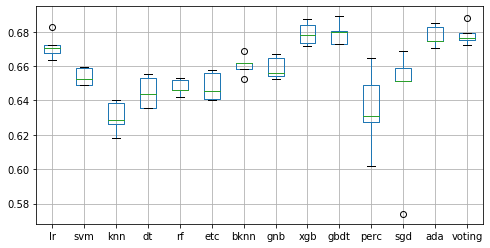

In [30]:
# k-fold cross-validation for the modules above
# using stratified cross-validation to deal with unbalance data
from sklearn.model_selection import cross_val_score, StratifiedKFold
from IPython.core.pylabtools import figsize
res = {}
for k, v in default_modules.items():
    scores = cross_val_score(v, X, y, cv=StratifiedKFold(5))
    res[k] = scores
    print(f"{k} => Accuracy: {scores.mean():0.4f} (+/- {scores.std() * 2:0.4f})")
figsize(8, 4)
pd.DataFrame(res).boxplot()
plt.show()

# 課題２: モデルの改善を行おう！
課題1で作成した各モデルについて、どうすればさらに良い精度を出すことができるのか、パラメータの調整や特徴量の選定などを行いましょう。
最後に、この課題において最善と考える特徴量とモデルを述べ、その理由も示してください。

まず、選定した特徴量を用いて、課題１で行ったStep1〜Step3 を行いましょう。ただし、Step 2〜Step 3の処理は、preprocessingという関数で定義してください。ここで定義した関数を用いて評価を行います。
引数には、読み込んだデータを指定してください。返り値には、前処理を行った後の選定した特徴量 ( X )とmarital ( y )を指定してください。

In [31]:
### Step 1　　データの読み込み
raw_data = pd.read_csv('train.csv')
train_data, test_data = train_test_split(raw_data, test_size=0.1, random_state=RAND_SEED)
num_attrs = ["age"]
cat_attrs = ["job", "education", "default", "housing", "loan", "contact"]
feature_attrs = num_attrs + cat_attrs
target = ["marital"]
raw_data.marital.value_counts()

married     12141
single       5605
divorced     2254
Name: marital, dtype: int64

次に、この課題における最善なモデルを構築しましょう。課題１で使用したモデル以外を使用しても構いません。

#### Using pipeline api to build a flexible module
Pipeline is a set of useful apis provided by sklearn which allow programmers
to reuse and combine their data processing procedures freely.

In [32]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

num_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    MinMaxScaler(),
)

num_pipeline_binning = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    KBinsDiscretizer()
)

preprocessing_onehot = make_column_transformer(
    (num_pipeline_binning, num_attrs),
    (OneHotEncoder(), cat_attrs),
)

preprocessing_ordinal = make_column_transformer(
    (num_pipeline, num_attrs),
    (OrdinalEncoder(), cat_attrs),
)

full_pipeline = make_pipeline(
    preprocessing_onehot,
    #TruncatedSVD(random_state=RAND_SEED, n_components=25),
    #PCA(random_state=RAND_SEED, n_components=0.90),
    #random_forest,
    #xgb,
    #PolynomialFeatures(degree=2),
    #GaussianNB(),
    #LogisticRegression(random_state=RAND_SEED),
    #SVC(),
    gbdt,
    #voting
    #DecisionTreeClassifier(),
    #KNeighborsClassifier(),
)

full_pipeline.fit(train_data[feature_attrs], train_data[target])
print(f"acc: {accuracy_score(full_pipeline.predict(test_data[feature_attrs]), test_data[target]):.4f}")

acc: 0.6690


### 考察１
この課題において最善と考える特徴量を述べ、その理由も示してください。

The 9 features provided for predicting are age, job, 
education, default, housing, loan, contact, month, day_of_week.

Next, I will try 2 methods to discard irrelevant features. 

### 1.Use tree-based methods (random forest or extra trees) to determine feature importance. 

Feature ranking by random forest:
age => importance: 0.6322825593617499
job => importance: 0.1696878874080125
education => importance: 0.11797478989961092
default => importance: 0.024228050563519656
housing => importance: 0.019779504732143644
loan => importance: 0.019776332283839477
contact => importance: 0.016270875751123983


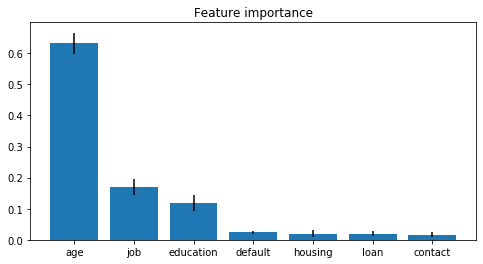

In [33]:
from sklearn.ensemble import ExtraTreesClassifier

X, y = raw_data[feature_attrs], raw_data[target]
X = preprocessing_ordinal.fit_transform(X)
etc = ExtraTreesClassifier(n_estimators=100, max_depth=20)
etc.fit(X, y)
importances = etc.feature_importances_
std = np.std([tree.feature_importances_ for tree in etc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking by random forest:")
for f in range(X.shape[1]):
    i = indices[f]
    print(f"{feature_attrs[i]} => importance: {importances[i]}")

plt.figure()
plt.title("Feature importance")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices])
plt.xticks(range(X.shape[1]), np.array(feature_attrs)[indices])
plt.show()

### 2.Feature ranking with recursive feature elimination and cross-validated (RFECV) selection of the best number of features.

Run cross validation on all combinations of input features
and choose the feature combination with the highest accuracy for a specific predicting module

Optimal features for linear regression: ['age', 'job', 'education', 'default', 'contact']


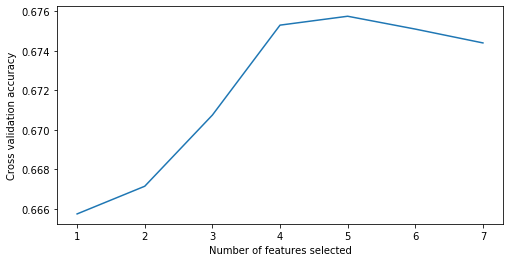

In [34]:
# RFECV for linear regression
def optimal_features(features, mask):
    return [item[0] for item in zip(features, mask) if item[1]]


from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=lr, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, y)
print(f'Optimal features for linear regression: {optimal_features(feature_attrs, rfecv.support_)}')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation accuracy")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

I gained about 1% accuracy boost on default linear regression module by simply eliminating some features.

### Next, run RFECV on the modules tried in 課題１

In [35]:
# modules_list = ['lr','dt','rf','etc','xgb','gbdt','sgd', 'ada']
# optimal_features_for_default_modules = {}
# for name in modules_list:
#     print(f'Optimal features for {name}:')
#     rfecv = RFECV(estimator=default_modules[name], cv=StratifiedKFold(6), scoring='accuracy')
#     rfecv.fit(X, y)
#     res = optimal_features(feature_attrs, rfecv.support_)
#     optimal_features_for_default_modules[name] = res
#     print(res)
#     print(f'Max accuracy for {name}:')
#     print(f'{max(rfecv.grid_scores_):.4f}')

In [36]:
import json

def store(data, name):
    with open(name, 'w') as fw:
        json.dump(data,fw)

def load(name):
    with open(name,'r') as f:
        data = json.load(f)
        return data
    
# store(optimal_features_for_default_modules, "opt_features.json")
optimal_features_for_default_modules = load('opt_features.json')

### 考察２
この課題において最善と考えるモデルを述べ、その理由も示してください。

I would like to use grid search to find better parameters for XGBClassifier, LogisticRegression and RandomForest.
Then try voting classifier to boost module performance. 
Restricted by the cpu performance, only a small-scale searches can be performed.

In [37]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import time

kflod=StratifiedKFold(5)
xgb_model = XGBClassifier(nthread = 6)
param_grid = dict(
    max_depth = [4, 5, 6, 7],
    learning_rate = [0.01, 0.1, 0.3],
    n_estimators = [100, 200]
)

X2 = raw_data[optimal_features_for_default_modules['xgb']]
X3 = preprocessing_onehot.fit_transform(X2)
X2 = preprocessing_ordinal.fit_transform(X2)

start = time.time()
#grid = GridSearchCV(xgb_model, param_grid, cv=kflod, scoring='accuracy')
#grid.fit(X2, y)
#print('GridSearchCV process use %.2f seconds'%(time.time()-start))
#print(grid.best_params_)

In [66]:
def kfoldTest(clr, x, y):
    scores = cross_val_score(clr, x, y, cv=kflod)
    print(f"Accuracy: {scores.mean():0.4f} (+/- {scores.std() * 2:0.4f})")
    
def accTest(clr, trainX, trainY, testX, testY):
    clr.fit(trainX, trainY)
    print(f"acc: {accuracy_score(clr.predict(testX), testY):.4f}")
    
kfoldTest(XGBClassifier(nthread = 6, max_depth=6, subsample=0.8, n_estimators=150), X2, y)

Accuracy: 0.6816 (+/- 0.0124)


In [39]:
lr_module = LogisticRegression(solver='saga', l1_ratio=0.2)
param_grid = dict(
    tol = [1e-2, 1e-3, 1e-4, 1e-5],
    penalty = ['l1', 'l2', 'elasticnet'],
    C = [1, 1.1, 1.2, 1.3, 1.4],
)
start = time.time()
#grid = GridSearchCV(lr_module, param_grid, cv=kflod, scoring='accuracy')
#grid.fit(X2, y)
#print('GridSearchCV process use %.2f seconds'%(time.time()-start))
#print(grid.best_params_)

In [40]:
kfoldTest(LogisticRegression(C=1.2, penalty='l1', tol=0.001), X2, y)

Accuracy: 0.6753 (+/- 0.0101)


In [41]:
rf_module = RandomForestClassifier()
param_grid = dict(
    n_estimators = [50, 100, 150],
    criterion = ['gini', 'entropy'],
    max_depth = [3,4,5,6,7],
)
start = time.time()
#grid = GridSearchCV(rf_module, param_grid, cv=kflod, scoring='accuracy')
#grid.fit(X2, y)
#print('GridSearchCV process use %.2f seconds'%(time.time()-start))
#print(grid.best_params_)

In [42]:
kfoldTest(RandomForestClassifier(max_depth=8, n_estimators=200), X2, y)

Accuracy: 0.6816 (+/- 0.0078)


最後に、以下の best_model に構築したモデルを記入してください。この best_model を使用して精度評価を行います。

In [69]:
voting_clr = VotingClassifier(estimators={
    ('rf', RandomForestClassifier(max_depth=8, n_estimators=200)),
    ('lr', LogisticRegression(C=1.2, penalty='l1', tol=0.001)),
    ('xgb', XGBClassifier(nthread = 6, max_depth=6, subsample=0.8, n_estimators=150))
    }, voting='soft')

full_pipeline = make_pipeline(
    preprocessing_ordinal,
    voting_clr
)

accTest(full_pipeline, train_data[feature_attrs], train_data[target],test_data[feature_attrs],test_data[target])
kfoldTest(voting_clr, X2, y)


acc: 0.6760
Accuracy: 0.6845 (+/- 0.0111)


In [84]:
def preprocessing():
    return preprocessing_ordinal.fit_transform(df_test_data[feature_attrs]), df_test_data[target]

full_pipeline.fit(raw_data[feature_attrs], raw_data[target])
best_model = full_pipeline  
accTest(full_pipeline, train_data[feature_attrs], train_data[target],test_data[feature_attrs],test_data[target])
pickle.dump(best_model, open('best_model.pkl','wb'))

### --------評価用--------
ここから下は評価用となります。上の欄にモデルを記入した後は、配布資料に書いてある手順に沿ってファイルを提出してください。

In [87]:
df_test_data = pd.read_csv('bank.csv')
X, y = preprocessing()
X_test = X
y_test = y

In [90]:
best2_model = pickle.load(open('best_model.pkl', 'rb'))
y_pred =best2_model.predict(X_test)
print('accuracy:{}'.format(accuracy_score(y_pred=y_pred, y_true=y_test)))

ValueError: Specifying the columns using strings is only supported for pandas DataFrames